Alice Simon, Céline Carré et Lucie Engel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Dataset

The data collected at baseline include breast ultrasound images among women in ages between 25 and 75 years old. This data was collected in 2018. The number of patients is 600 female patients. The dataset consists of 780 images with an average image size of 500*500 pixels. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into three classes, which are normal, benign, and malignant.

Reference : Al-Dhabyani W, Gomaa M, Khaled H, Fahmy A. Dataset of breast ultrasound images. Data in Brief. 2020 Feb;28:104863. DOI: 10.1016/j.dib.2019.104863.

## Load data


In [ ]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pathlib
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms 
import os 
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import torch.optim as optim 
torch.manual_seed(25)
import random
random.seed(11)
import segmentation_models_pytorch as smp

In [ ]:
cd "/content/drive/MyDrive/Projet_DL/Dataset_BUSI_with_GT"

/content/drive/MyDrive/Projet_DL/Dataset_BUSI_with_GT


In [ ]:
# inspi https://www.kaggle.com/code/vanvalkenberg/segmentation-model-for-breast-cancer

def load_data(path, shape):
    names = os.listdir(path)
    
    patient_num = []
    ultrasound_path = []
    mask_path = []
    
    for i in range(len(names)):
        patient_num.append(names[i].split(')')[0])

    patient_num = list(set(patient_num))

    for i in range(len(patient_num)):
        ultrasound_name = patient_num[i]+').png'
        mask_name = patient_num[i]+')_mask.png'
        ultrasound_path.append(os.path.join(path,ultrasound_name))
        mask_path.append(os.path.join(path,mask_name))
    
    dict = {'ultrasound_path': ultrasound_path, 'mask_path': mask_path, 'class' : [path]*len(ultrasound_path)}
    return pd.DataFrame(dict) 

In [ ]:
SHAPE = 256
benign_df = load_data('benign', SHAPE)
malignant_df = load_data('malignant', SHAPE)
normal_df = load_data('normal', SHAPE)

#data_df = pd.concat([benign_df, malignant_df, normal_df])
#data_df.to_csv("whole_dataset_df.csv")
#data_df # 780 exams 

In [ ]:
data_df = pd.read_csv("whole_dataset_df.csv")

## Train, Valid, Test split

In [ ]:
from sklearn.model_selection import train_test_split


train_and_valid_df, test_df = train_test_split(data_df, test_size=0.1, stratify=data_df['class'], random_state = 11)

train_and_valid_df # 702 samples
test_df # 78 samples

train_df, valid_df = train_test_split(train_and_valid_df, test_size=0.2, stratify=train_and_valid_df['class'], random_state = 11)

In [ ]:
train_df # 561 samples
valid_df # 141 samples

Unnamed: 0                ultrasound_path  \
756         109         normal/normal (28).png   
25           25         benign/benign (56).png   
457          20  malignant/malignant (198).png   
686          39         normal/normal (69).png   
510          73   malignant/malignant (19).png   
..          ...                            ...   
350         350        benign/benign (199).png   
327         327        benign/benign (159).png   
424         424         benign/benign (93).png   
469          32   malignant/malignant (76).png   
434         434        benign/benign (136).png   

                              mask_path      class  
756         normal/normal (28)_mask.png     normal  
25          benign/benign (56)_mask.png     benign  
457  malignant/malignant (198)_mask.png  malignant  
686         normal/normal (69)_mask.png     normal  
510   malignant/malignant (19)_mask.png  malignant  
..                                  ...        ...  
350        benign/benign (199)_mask.png     benign  
327        benign/benign (159)_mask.png     benign  
424         benign/benign (93)_mask.png     benign  
469   malignant/malignant (76)_mask.png  malignant  
434        benign/benign (136)_mask.png     benign  

[141 rows x 4 columns]

In [ ]:
test_df

Unnamed: 0                ultrasound_path  \
385         385        benign/benign (274).png   
301         301        benign/benign (385).png   
433         433        benign/benign (196).png   
138         138        benign/benign (379).png   
573         136   malignant/malignant (37).png   
..          ...                            ...   
236         236        benign/benign (213).png   
472          35   malignant/malignant (74).png   
734          87         normal/normal (99).png   
564         127   malignant/malignant (73).png   
511          74  malignant/malignant (208).png   

                              mask_path      class  
385        benign/benign (274)_mask.png     benign  
301        benign/benign (385)_mask.png     benign  
433        benign/benign (196)_mask.png     benign  
138        benign/benign (379)_mask.png     benign  
573   malignant/malignant (37)_mask.png  malignant  
..                                  ...        ...  
236        benign/benign (213)_mask.png     benign  
472   malignant/malignant (74)_mask.png  malignant  
734         normal/normal (99)_mask.png     normal  
564   malignant/malignant (73)_mask.png  malignant  
511  malignant/malignant (208)_mask.png  malignant  

[78 rows x 4 columns]

In [ ]:
def plot_class_distribution (df_train, df_valid, df_test):
    """Plot distributions of classes for training and validation datasets."""
    barplot = plt.figure(figsize=(16,4))
    barplot.suptitle("Class balance")

    barplot.add_subplot(1,3,1)
    plt.title("Training dataset")
    df_train['class'].hist()

    barplot.add_subplot(1,3,2)
    plt.title("Validation dataset")
    df_valid['class'].hist()

    barplot.add_subplot(1,3,3)
    plt.title("Testing dataset")
    df_test['class'].hist()

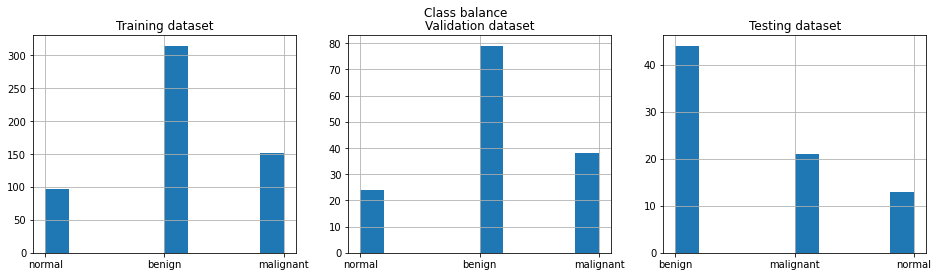

In [ ]:
plot_class_distribution(train_df, valid_df, test_df)

## Create datasets and dataloaders from dataframes

In [ ]:
us_transform = transforms.Compose([   
    #transforms.Grayscale(),
    transforms.Resize(size=(256,256)),  
    transforms.ToTensor()                    
])

mask_transform = transforms.Compose([  
    transforms.Grayscale(),
    transforms.Resize(size=(256,256)),  
    transforms.ToTensor()                    
])
                

class CustomDataset(Dataset): # on crée le dataset 
    def __init__(self, dataframe, us_transform = None, mask_transform = None, target_transform = None):
        self.df = dataframe
        self.us_transform = us_transform
        self.mask_transform = mask_transform
        self.target_transform = target_transform
    
    def __len__(self): # longueur du dataset 
        return len(self.df)
    
    def __getitem__(self, idx): # fonction qui permet de récupérer un élément 
        ultrasound_path = self.df.iloc[idx, self.df.columns.get_loc('ultrasound_path')]
        mask_path = self.df.iloc[idx, self.df.columns.get_loc('mask_path')]
        label = self.df.iloc[idx, self.df.columns.get_loc('class')]
        
        ultrasound_img = Image.open(ultrasound_path)     
        mask_img = Image.open(mask_path)  
        
        if self.us_transform:
            ultrasound_img = self.us_transform(ultrasound_img)
        if self.mask_transform : 
            mask_img = self.mask_transform(mask_img)
        
        if label == "normal" : label = torch.tensor([1,0,0])
        elif label == "benign" : label = torch.tensor([0,1,0])
        elif label == "malignant" : label = torch.tensor([0,0,1])
        else : print("hay un problema")

        if self.target_transform:   
            label = self.target_transform(label)
        
        if mask_img.shape == torch.Size([3, 256, 256]): print(mask_path)
            
        return ultrasound_img, mask_img, label 
    
    def collate_fn(self, batch): 
        #https://wandb.ai/ishandutta/semantic_segmentation_unet/reports/Semantic-Segmentation-with-UNets-in-PyTorch--VmlldzoyMzA3MTk1#2.5-dataloaders
        ims, masks = list(zip(*batch))
        ultrasound_imgs = torch.cat([im for im in ims])
        mask_imgs = torch.cat([mask for mask in masks])
        return ultrasound_imgs, mask_imgs


In [ ]:
train_dataset = CustomDataset(train_df, us_transform, mask_transform)
valid_dataset = CustomDataset(valid_df, us_transform, mask_transform)
test_dataset = CustomDataset(test_df, us_transform, mask_transform)

In [ ]:
BATCH_SIZE = 10

train_dataloader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
valid_dataloader = DataLoader(dataset = valid_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_dataloader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
# DEBUGG
IDX = 2
print(f"Shape of ultrasound image : {train_dataset.__getitem__(IDX)[0].shape}") # 3 channels --> 1 channel (Grayscale transform)
print(f"Shape of mask : {train_dataset.__getitem__(IDX)[1].shape}") # 1 channel
print(f"Shape of Label : {train_dataset.__getitem__(IDX)[2].shape}") # 1 channel
train_dataset.__getitem__(IDX)[1]

Shape of ultrasound image : torch.Size([3, 256, 256])
Shape of mask : torch.Size([1, 256, 256])
Shape of Label : torch.Size([3])


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [ ]:
def visualization_several_images(pytorch_dataset, number = 8):
    """ Show random images with label from pytorch dataset."""

    figure = plt.figure(figsize= (5,20))
    cols, rows = 2, number 
    for i in range(1, 2*number + 1,2):
        
        sample_idx = torch.randint(len(pytorch_dataset), size=(1,)).item()
        ultrasound_img, mask_img, label = pytorch_dataset.__getitem__(sample_idx)

        if label[0].item() == 1. : label = "normal" 
        elif label[1].item() == 1. : label = "benign"
        elif  label[2].item() == 1. : label = "malignant"

        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(ultrasound_img.permute(1, 2, 0).squeeze(),cmap='gray')
        
        figure.add_subplot(rows, cols, i + 1)
        plt.title(label)
        plt.axis("off")
        plt.imshow(mask_img.permute(1, 2, 0).squeeze(),cmap='gray')
        
    plt.show()

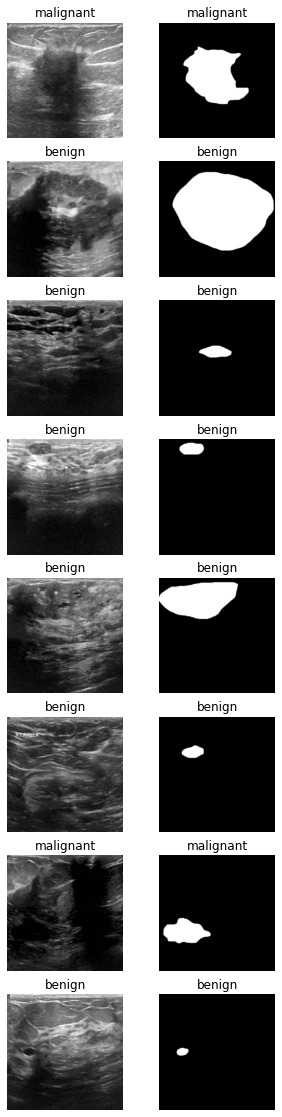

In [ ]:
visualization_several_images(train_dataset, 8)

# Model

U-Net est un réseau de neurones à convolution développé pour la segmentation d'images biomédicales 
https://towardsdatascience.com/a-detailed-explanation-of-the-attention-u-net-b371a5590831

## Define model, losses and optimizers

In [ ]:
# LOSSES
# source : https://www.kaggle.com/code/vatsalmavani/pytorch-lung-segmentation-using-pretrained-u-net
import torch.nn.functional as F

def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [ ]:
#https://segmentation-models-pytorch.readthedocs.io/en/latest/_modules/segmentation_models_pytorch/efficientunetplusplus/model.html#EfficientUnetPlusPlus

N_EPOCHS = 30

Encoder = 'resnet34'
Weights = 'imagenet'

"""
aux_params: Dictionary with parameters of the auxiliary output (classification head). Auxiliary output is built 
            on top of encoder if **aux_params** is not **None** (default). Supported params:
                - classes (int): A number of classes
                - pooling (str): One of "max", "avg". Default is "avg"
                - dropout (float): Dropout factor in [0, 1)
                - activation (str): An activation function to apply "sigmoid"/"softmax" (could be **None** to return logits)
"""

model = smp.Unet(
    encoder_name = Encoder,
    encoder_weights = Weights,
    in_channels = 3,
    classes = 1, # tumeur 
    activation = None,
    aux_params = {"classes" : 3, "pooling" : "max", "activation" : "softmax"}
)

model = model.to(device)

loss_fn_mask = MixedLoss(alpha = 10.0,gamma = 2.0)
loss_fn_label = nn.CrossEntropyLoss()

#opt = optim.Adam(model.parameters(),lr = LR)

opt_seg = optim.Adam([
            {'params': model.encoder.parameters()},
            {'params': model.decoder.parameters()},
            {'params': model.segmentation_head.parameters()}
            ], lr=1e-4)

opt_label = optim.Adam(model.classification_head.parameters(),lr=1e-5)


In [ ]:
model

In [ ]:
for i, (us, mask, label) in enumerate(train_dataloader):
  us = us.to(device)
  out = model(us)
  print(out[0].shape, out[1].shape)
  break

## Train model

In [ ]:
def train_loop_label(dataloader, model, loss_fn_mask, loss_fn_label, opt_seg, opt_label):
    size = len(dataloader.dataset)
    
    for batch, (X, mask, label) in enumerate(dataloader):
        X = X.to(device)
        mask = mask.to(device)
        label = label.to(device)


        """
        opt_seg.zero_grad()
        mask_logits, label_logits = model(X)
        loss_mask = loss_fn_mask(mask_logits, mask)
        loss_mask.backward()
        opt_seg.step()

        opt_label.zero_grad()
        mask_logits, label_logits = model(X)
        loss_label =  loss_fn_label(label_logits, label.argmax(1))
        loss_label.backward()
        opt_label.step()
        """
        
        # Compute prediction and loss
        mask_logits, label_logits = model(X)

        loss_mask = loss_fn_mask(mask_logits, mask)
        loss_label =  loss_fn_label(label_logits, label.argmax(1))

        opt_label.zero_grad()
        opt_seg.zero_grad()

        loss_mask.backward(retain_graph = True)
        loss_label.backward()
        
        opt_label.step()
        opt_seg.step()
        
        """
        optimizer.zero_grad()
        loss_mask.backward(retain_graph = True)
        loss_label.backward()
        optimizer.step()
        """     

        if batch % 10 == 0:
            loss_mask, loss_label, current = loss_mask.item(), loss_label.item(), batch * len(X)
            print(f"train mask loss: {loss_mask}; train label loss: {loss_label} [{current}/{size}]")


def test_loop_label(dataloader, model, loss_fn_mask, loss_fn_label):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss_mask, test_loss_label, correct = 0, 0, 0

    with torch.no_grad():
        for X, mask, label in dataloader:
            
            X = X.to(device)
            mask = mask.to(device)
            label = label.to(device)

            mask_logits, label_logits = model(X)
            loss_mask = loss_fn_mask(mask_logits, mask)
            loss_label =  loss_fn_label(label_logits, label.argmax(1))
            
            test_loss_mask += loss_mask.item()
            test_loss_label += loss_label.item()
            correct += (label.argmax(1) == label_logits.argmax(1)).type(torch.float).sum().item()

    test_loss_mask /= num_batches
    test_loss_label /= num_batches
    accuracy = correct / size
    print(accuracy)
    
    print(f"Test Error Mask : {test_loss_mask}; Test Error Label : {test_loss_label};  Accuracy: {(100*accuracy):>0.1f}% \n")
    
    return test_loss_mask, test_loss_label, accuracy

In [ ]:
loss_list = []
best_model = model
lowest_mask_loss, highest_accuracy = 1000, 0 
for t in range(N_EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop_label(train_dataloader, model, loss_fn_mask, loss_fn_label, opt_seg, opt_label)
    test_loss_mask, test_loss_label, accuracy = test_loop_label(valid_dataloader, model, loss_fn_mask, loss_fn_label)
    
    if (accuracy >= highest_accuracy) and (test_loss_mask <= lowest_mask_loss) : 
      print("Updating best model....\n")
      best_model = model
      highest_accuracy = accuracy
      lowest_mask_loss = test_loss_mask

    loss_list.append(test_loss_mask)

print("Done!")

Epoch 1
-------------------------------
train mask loss: 4.857308387756348; train label loss: 0.8739298582077026 [0/561]
train mask loss: 3.870312213897705; train label loss: 0.8733670115470886 [100/561]
train mask loss: 3.289691686630249; train label loss: 1.2539665699005127 [200/561]
train mask loss: 2.4000792503356934; train label loss: 0.8628942370414734 [300/561]
train mask loss: 3.238004684448242; train label loss: 0.8362863659858704 [400/561]
train mask loss: 2.9750924110412598; train label loss: 0.7587958574295044 [500/561]
0.6808510638297872
Test Error Mask : 2.4864553769429523; Test Error Label : 0.8517340103785197;  Accuracy: 68.1% 

Updating best model....

Epoch 2
-------------------------------
train mask loss: 2.3487391471862793; train label loss: 0.9409017562866211 [0/561]
train mask loss: 2.676480293273926; train label loss: 0.9479185342788696 [100/561]
train mask loss: 1.5461218357086182; train label loss: 0.7364689111709595 [200/561]
train mask loss: 1.72225069999694

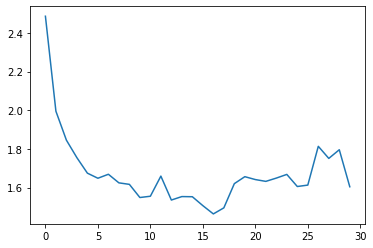

In [ ]:
plt.plot(loss_list)

In [ ]:
#torch.save(model.state_dict(), '/content/drive/MyDrive/Projet_DL/state_dict/youpi_pretrained_unet_19_epochs_2opt_10-4_10-5_bs10_ch_acc81.6')

In [ ]:
torch.save(best_model.state_dict(), '/content/drive/MyDrive/Projet_DL/state_dict/youpi_pretrained_unet_19_epochs_2opt_10-4_10-5_bs10_ch_acc87.9_loss1.54')

## Model Predictions

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
PATH = '/content/drive/MyDrive/Projet_DL/state_dict/youpi_pretrained_unet_19_epochs_2opt_10-4_10-5_bs10_ch_acc87.9_loss1.54'

Encoder = 'resnet34'
Weights = 'imagenet'

model = smp.Unet(
    encoder_name = Encoder,
    encoder_weights = Weights,
    in_channels = 3,
    classes = 1, # tumeur 
    activation = None,
    aux_params = {"classes" : 3, "pooling" : "max", "activation" : "softmax"}
)

model = model.to(device)
model.load_state_dict(torch.load(PATH))
model.eval()

In [ ]:
def visualization_predictions(pytorch_dataset, model, number = 8):
    """ Show random images with label from pytorch dataset."""
    c = 0 
    #figure = plt.figure(figsize= (10,20))
    figure = plt.figure(figsize= (10,500))
    cols, rows = 3, number 
    for i in range(1, 3 * number + 1,3):
        
        sample_idx = torch.randint(len(pytorch_dataset), size=(1,)).item()
        #ultrasound_img, mask_img, label = pytorch_dataset.__getitem__(sample_idx)
        ultrasound_img, mask_img, label = pytorch_dataset.__getitem__(c)
        
        if label[0].item() == 1. : label = "normal" 
        elif label[1].item() == 1. : label = "benign"
        elif  label[2].item() == 1. : label = "malignant"
        
        figure.add_subplot(rows, cols, i)
        plt.title("Ultrasound Image")
        plt.axis("off")
        plt.imshow(ultrasound_img.permute(1, 2, 0).squeeze(),cmap='gray')
        
        figure.add_subplot(rows, cols, i + 1)
        plt.title(f"Target : {label}")
        plt.axis("off")
        plt.imshow(mask_img.permute(1, 2, 0).squeeze(),cmap='gray')
        
        figure.add_subplot(rows, cols, i + 2)
        ultrasound_img = ultrasound_img[None, :, :, :] # add dimension
        ultrasound_img = ultrasound_img.to(device) # load to gpu
        mask_pred, label_pred = model(ultrasound_img)
        mask_pred = torch.sigmoid(mask_pred)
        mask_pred = torch.round(mask_pred)
        #mask_pred = torch.softmax(mask_pred, dim = 1) # apply softmax 
        mask_pred = torch.squeeze(mask_pred,dim = 0).cpu() # remove dimension and put on cpu
        if torch.argmax(label_pred).item() == 0. : label_pred = "normal" 
        elif torch.argmax(label_pred).item() == 1 : label_pred = "benign"
        elif  torch.argmax(label_pred).item() == 2 : label_pred = "malignant"

        plt.title(f"Prediction :{label_pred}")
        plt.axis("off")
        plt.imshow(mask_pred.detach().permute(1, 2, 0).squeeze(),cmap='gray')

        c+=1
        
    plt.show()

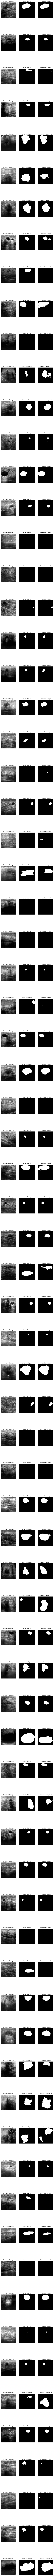

In [ ]:
#_ = torch.manual_seed(24)

visualization_predictions(test_dataset, model, number = 78)

In [ ]:
# ACCURACY SUR LE JEU DE TEST
loss_fn_mask = MixedLoss(alpha = 10.0,gamma = 2.0)
loss_fn_label = nn.CrossEntropyLoss()

test_loss_mask, test_loss_label, correct = 0,0,0

for X, mask, label in test_dataloader:
    
    X = X.to(device)
    mask = mask.to(device)
    label = label.to(device)

    mask_logits, label_logits = model(X)
    loss_mask = loss_fn_mask(mask_logits, mask)
    loss_label =  loss_fn_label(label_logits, label.argmax(1))
    
    test_loss_mask += loss_mask.item()
    test_loss_label += loss_label.item()
    correct += (label.argmax(1) == label_logits.argmax(1)).type(torch.float).sum().item()

test_loss_mask /= len(test_dataloader.dataset)
test_loss_label /= len(test_dataloader.dataset)
accuracy = correct/len(test_dataloader.dataset)

print(test_loss_mask, test_loss_label, accuracy) 

0.15874785108444017 0.07704040943047939 0.8076923076923077


In [ ]:
# ACCURACY SUR LE JEU DE VALIDATION
loss_fn_mask = MixedLoss(alpha = 10.0,gamma = 2.0)
loss_fn_label = nn.CrossEntropyLoss()

test_loss_mask, test_loss_label, correct = 0,0,0

l = 0

for X, mask, label in valid_dataloader:
    l += len(X)
    X = X.to(device)
    mask = mask.to(device)
    label = label.to(device)

    mask_logits, label_logits = model(X)
    loss_mask = loss_fn_mask(mask_logits, mask)
    loss_label =  loss_fn_label(label_logits, label.argmax(1))
    
    test_loss_mask += loss_mask.item()
    test_loss_label += loss_label.item()
    correct += (label.argmax(1) == label_logits.argmax(1)).type(torch.float).sum().item()

test_loss_mask /= len(valid_dataloader.dataset)
test_loss_label /= len(valid_dataloader.dataset)
accuracy = correct/len(valid_dataloader.dataset)

print(test_loss_mask, test_loss_label, accuracy)

print(l, len(valid_dataloader.dataset))

0.15791297603583504 0.0700854887353613 0.8865248226950354
141 141
